# Identifying a SPAM - using NLP with Python

Idea is to identify if an SMS Phone message is a spam using Natural Language Processing techniques.

## Get the Data

Example data for this analysis is from SMS Spam Collectio Dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).

The file we are using contains a collection of more than 5 thousand SMS phone messages.

In [50]:

import os
os.chdir('C:/_Working Files/00 Udemy Study Code/00 Udemy Course/Python-Data-Science-and-Machine-Learning-Bootcamp/Machine Learning Sections/Natural-Language-Processing/smsspamcollection')


messages = [line.rstrip() for line in open('SMSSpamCollection')]
print(len(messages))
print(messages[0:10])

5574
['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'ham\tOk lar... Joking wif u oni...', "spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'ham\tU dun say so early hor... U c already then say...', "ham\tNah I don't think he goes to usf, he lives around here though", "spam\tFreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, \xc2\xa31.50 to rcv", 'ham\tEven my brother is not like to speak with me. They treat me like aids patent.', "ham\tAs per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune", 'spam\tWINNER!! As a valued network customer you have been selected to receivea \xc2\xa3900 prize reward! To claim call 0906

### From above code looks like it is a tab limited file; use pandas to retreive the file now

In [51]:
import pandas as pd
messages = pd.read_csv('SMSSpamCollection', sep='\t',names=["label", "message"])
messages.head()
messages.describe()
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

### Find the right features; how about the length of message; spams are longer

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000EA31198>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000EA2D828>], dtype=object)

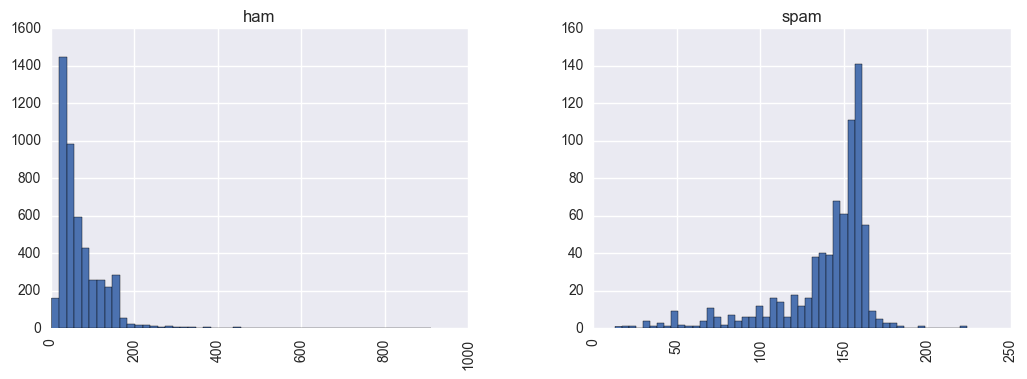

In [53]:
messages['length'] = messages['message'].apply(len)
messages.head()
import sys
sys.path.append("C:\seaborn-master")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

messages.hist(column='length', by='label', bins=50,figsize=(12,4))  # Spams are longer

### Text Pre-processing & Tokenizing

In [54]:

import string
import nltk
nltk.data.path.append('C:\\nltk') 
from nltk.corpus import stopwords


def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]


message_processed = messages['message'].apply(text_process)


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


### Creating the sparse matrix 

In [57]:

# ## Vectorization

# 
# 
# Vectorization using the bag-of-words model:
# 
# 1. Count how many times does a word occur in each message (Known as term frequency)
# 
# 2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
# 
# 3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

# **Creating the sparse matrix - word count for each message**

from sklearn.feature_extraction.text import CountVectorizer # This creates a sparse matrix (matrix of token counts); features in the context are the tokens (UNIQUE WORDS) and the number of times they appear in the document
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message']) #does some preprocessing; and fits all the documents into a sparse matrix
print(len(bow_transformer.vocabulary_)) # total number of unique words 11425


#Let's see one example to get a better understading

message_part = messages.message[3]
bow4 = bow_transformer.transform([message_part]) # transforming a sparse matrix into (x,y) for a particular message - just for viewing purposes; the sparse matrix is defined earlier
print(bow4) #7 unique words in messages.message[3]
print(bow4.shape) #matrix length as expected 1 (just for one message)x 11425 (unique words)
print(bow_transformer.get_feature_names()[4068]) # Getting the feature name
print(bow_transformer.get_feature_names()[9554])


# Getting back to ALL the messages

messages_bow = bow_transformer.transform(messages['message']) # Preprocessing - Tokenize - and now Vectorize and sparse matrix 

print('Shape of Sparse Matrix: ', messages_bow.shape) #5572 X 11425 (total number of documents/messages X  unique words)
print('Amount of Non-Zero occurences: ', messages_bow.nnz) # proof that it is a sparse matrix; 99.92% of the cells are zero

sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity))) #sparsity is 0.08...which means 0.08% of cells are filled with some NZ values


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


11425
  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)
U
say
('Shape of Sparse Matrix: ', (5572, 11425))
('Amount of Non-Zero occurences: ', 50548)
sparsity: 0.0


### TF-IDF on the sparse matrix

In [58]:
''' Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.
# 
# **TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 
# 
# *TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*
# 
# **IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 
# 
# *IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*
# 
# **Example:**
# 
# Consider a document containing 100 words wherein the word cat appears 3 times. 
# 
# The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
# ____
# 
# Let's go ahead and see how we can do this in SciKit Learn:
'''

from sklearn.feature_extraction.text import TfidfTransformer #tf-idf transformation
tfidf_transformer = TfidfTransformer().fit(messages_bow) #fitting the message; message_bow is the sparse matrix

# We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?

print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']]) #3.28 in more documents
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']]) # 8.52 in lesser documents


# To transform the entire bag-of-words corpus into TF-IDF corpus at once:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape) #5572 * 11425

3.28005242674
8.5270764989
(5572, 11425)


### Training the model

In [60]:

# ## Training a model
# With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.
# We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label']) #fit the tfidf to the message labels

# Let's try classifying our single random message and checking how we do:

print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

('predicted:', 'ham')
('expected:', 'ham')


### Model Evaluation

There are several ways to evaluate a classification model; a summary of metrics is shown below:

![Metrics](Capture.PNG)
![Precision and Recall](Capture1.PNG)


In [64]:
# Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)


# We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:
# Precision = True Positive / All positives predicted (this can have some False Positives as well) ||| Measure of quality 
# Recall = True Positive / All actual positive (this will have some false negatives as well) ||| Measure of quantity
# F1 score = harmonic average of p and r; 0 is worst and 1 is the best    

from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']
             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      4825
       spam       1.00      0.85      0.92       747

avg / total       0.98      0.98      0.98      5572



### Splitting into training and test data - and doing the same thing
### Also making use of Scikit Learn's  PIPELINE functionaility - make things easier (encapsulation technique)

In [66]:

from sklearn.cross_validation import train_test_split

msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.2)
print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))


# Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])


# Now we can directly pass message text data and the pipeline will do our pre-processing for us!
# We can treat it as a model/estimator API:

pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))


(4457, 1115, 5572)


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      1017
       spam       0.72      1.00      0.83        98

avg / total       0.97      0.97      0.97      1115

